## Setup ##

Here is the initial setup code for the program, the usual imports for data manipulation and visualisation are involved. 

I decided to import specific modules from sklearn to allow the modelling of specific techniques.

The data has been imported to two local variables for later manipulations and a combination formed to apply changes to the test data after verification on the training data.

In [1]:
# data analysis and manipulation
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron

# importing the data
train_df = pd.read_csv('Input/Train.csv')
test_df = pd.read_csv('Input/TestData.csv')
combine = [train_df, test_df]

out = True

___

## Feature Engineering ##

In [2]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


Here i have simply printed out the training data values to verify that the data imported matches. 
After this point it is critical to quantify the columns, this is done to remove any potential features that are not
important or refine features.

A quick look at the head of the head of the data will allow for analysis of some of the features.

In [3]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Here we can see that the "Name", "Ticket" and "Cabin" features may not be useful and will need to be removed or adjusted later.

Another important test is the verify that each feature has an input for every entry.

In [4]:
if out: 
    train_df.info()
    print('_'*40)
    test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

"Age" and "Cabin" do not have entries for all passengers in both datasets. "Embarked" does not for the training data and "Fare" is missing a single value in the test data.

Some features such as "Name" can also be simplified to allow them to be used in classification techniques.

To resolve these missing values different methods may be employed:

---

# Fixing Features #

## Age ##

Filling in the missing "Age" entries from the data is very important. Correlating the "Age" feature with other features to predict ages based on these can be done, this will allow for the filling of the data as accurately as possible but may not be perfect.

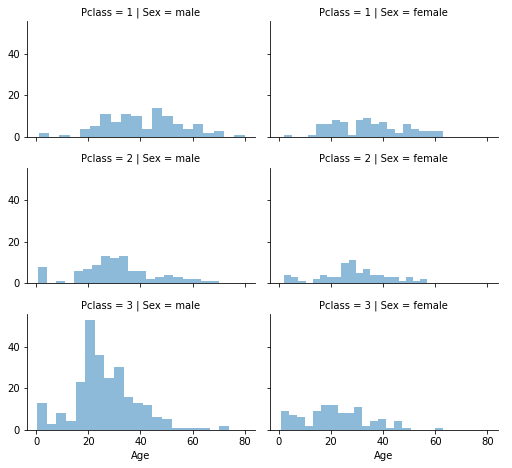

In [5]:
if out:
    grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=2.2, aspect=1.6)
    grid.map(plt.hist, 'Age', alpha=.5, bins=20)
    grid.add_legend()

Using a graph and plotting the "Pclass" in relation to "Sex" against "Age" shows for rough normal distribution curves. Using these will allow for reasonably accurate predictions of age for passengers. Using the median age based on "Sex" and "Pclass" will allow for extrapolation from the current data and generation of accurate data.

In [6]:
guess_ages = np.zeros((2,3))

#Mapping Sex to numeric values
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            #Taking the median age (Most Common) from the Pclass & Sex
            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

#Conversation of Age to type int for easier manipulation later.
dataset['Age'] = dataset['Age'].astype(int)

## Cabin ##

The "Cabin" feature has a wide variance along with a lack of data. This feature cannot be easily predicted so extrapolating from current data will not be easy or will result in very inaccurate data. The "Fare" feature may also be used to gain similar information that the "Cabin" feature would yield. This means that this feature can be removed with little to no impact on model accuracy.

While removing the "Cabin" feature other features that are not relevant may also be removed. The "Ticket" feature is simply a reference and "PassengerId" is not important in the training data as the key may be used if required.

In [7]:
#Removing Ticket and Cabin features from both training, PassengerId and test data
train_df = train_df.drop(['Ticket', 'Cabin', 'PassengerId'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

## Embarked ##

"Embarked" is missing some values in the training dataset, due to the low number of missing values simply replacing them with the most frequent value can be done. These values can then be mapped to numeric values for analysis.

In [8]:
freq_port = train_df.Embarked.dropna().mode()[0]

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    #Mapping Embarked to numeric value
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

## Fare ##

The test data is missing a single "Fare" value, this can be replaced with the median value. Due to being a single value being replaced this should be accurate enough.

In [9]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,1
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,0


After these manipulations "Fare", "Embarked" and "Age" should be filled in with representative data. Erroneous features such as "Cabin" have been removed which will allow for greater model accuracy.

---

# Feature Grouping #

## Age ##

The raw "Age" feature may not be as useful as given a smaller number of values. This will allow for correlation to the "Survived" value and give more general approximations.

In [10]:
#Cut the Age data into groups of equal value, for 5 groups this will generate the bands and show the
#Survival rate for each group

train_df['AgeGroup'] = pd.cut(train_df['Age'], 8)
train_df[['AgeGroup', 'Survived']].groupby(['AgeGroup'], as_index=False).mean().sort_values(by='AgeGroup', ascending=True)

,AgeGroup,Survived
0,"(0.34, 10.368]",0.593750
1,"(10.368, 20.315]",0.382609
2,"(20.315, 30.263]",0.323607
3,"(30.263, 40.21]",0.448649
4,"(40.21, 50.158]",0.383721
5,"(50.158, 60.105]",0.404762
6,"(60.105, 70.052]",0.235294
7,"(70.052, 80.0]",0.200000


There appear to be statistical differences between the groups at this granularity. Implementing these groups for the "Age" is done below.

In [11]:
#Creating map from Age to Agegroup based on the groupsize above that seems to give reasonable survival correlation
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 10, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 10) & (dataset['Age'] <= 20), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 20) & (dataset['Age'] <= 30), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 40), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 50), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 50) & (dataset['Age'] <= 60), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 60) & (dataset['Age'] <= 70), 'Age'] = 6
    dataset.loc[(dataset['Age'] > 70) & (dataset['Age'] <= 80), 'Age'] = 7
    dataset.loc[ dataset['Age'] > 80, 'Age']
    
#Removal of the "AgeGroup" now that "Age" has been mapped
train_df = train_df.drop(['AgeGroup'], axis=1)
combine = [train_df, test_df]

## Fare ##

The "Fare" feature can be grouped like "Age" was

In [12]:
train_df['FareGroup'] = pd.qcut(train_df['Fare'], 4)

train_df[['FareGroup', 'Survived']].groupby(['FareGroup'], as_index=False).mean().sort_values(by='FareGroup', ascending=True)

,FareGroup,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


Similarly to "Age" the groups seem to have statistical differences at this granularity so these make good breakpoints.

In [13]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareGroup'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,2.0,1,0,0,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3.0,1,0,3,1
2,1,3,"Heikkinen, Miss. Laina",1,2.0,0,0,1,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,3.0,1,0,3,0
4,0,3,"Allen, Mr. William Henry",0,3.0,0,0,1,0


Here we can see that "Age" and "Fare" have both been mapped to a numeric value based on the classifications set. 

---

# Feature Manipulation #

## Name ##

Titles may be an important feature that can be extracted from the "Name" feature.

In [14]:
#Showing all titles to quantify the range
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,0,1
Title,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


From this we can see that: "Master", "Miss", "Mr" and "Mrs" are the most common titles and correlate to the "Sex" feature. There are some other titles that are not as common but may be incorporated into other titles such as "Mme" to "Mrs"

While adding this new "Title" feature removing the name of the passengers may be done, as this is not an important feature.

The "Sex" feature may also be mapped to a numeric value, in the case of this data there are 2 values.

In [15]:
#Removing additional titles and incorporating alternatives to more common ones
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Misc')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
#Mapping the new titles to numeric values
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Misc": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
#Dropping the Name feature now titles has been added
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,2.0,1,0,0,0,1
1,1,1,1,3.0,1,0,3,1,3
2,1,3,1,2.0,0,0,1,0,2
3,1,1,1,3.0,1,0,3,0,3
4,0,3,0,3.0,0,0,1,0,1


## FamilyGroupSize ##

The next features to sort are "SibSp" and "Parch". These may be combined into a single feature, which may be called "FamilyGroupSize". Using this single feature will allow for more efficient classification.

In [16]:
for dataset in combine:
    dataset['FamilyGroupSize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilyGroupSize', 'Survived']].groupby(['FamilyGroupSize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

#Parch and SibSp can now be removed as FamilyGroupSize coveres both of these features
train_df = train_df.drop(['Parch', 'SibSp'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilyGroupSize
0,0,3,0,2.0,0,0,1,2
1,1,1,1,3.0,3,1,3,2
2,1,3,1,2.0,1,0,2,1
3,1,1,1,3.0,3,0,3,2
4,0,3,0,3.0,1,0,1,1


After the classification of "FamilyGroupSize" the data should be ready for analysis. The combinations inserted the "Survived" feature into the test data, i was unsure where this occurred but it can be removed. The data is then checked to ensure that they have not changed in size and the number of features is the same.

In [17]:
test_df = test_df.drop("Survived", axis=1)
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

## Applied Techniques ##
- Logistic Regression 
- KNN or k-Nearest Neighbours
- Support Vector Machines (SVM)
- Decision Tree
- Perceptron
- Artificial neural network

After the code snippet (using sklearn in these cases) the output value will be a % accuracy rating compared to the training data.

## Logistic Regression ##

In [18]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

81.59

---

## Support Vector Machines ##

In [19]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.28

---

## k-Nearest Neighbours ##

In [20]:
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

85.75

---

## Gaussian Naive Bayes ##

In [21]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

80.47

---

## Perceptron ##

In [22]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

79.91

---

## Random Forest Classifier ##

In [23]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

89.67

---

## Model Rankings ##

In [24]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Naive Bayes', 'Perceptron', 'Random Forest'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_gaussian, acc_perceptron, acc_random_forest]})
models.sort_values(by='Score', ascending=False)

,Model,Score
5,Random Forest,89.67
1,KNN,85.75
0,Support Vector Machines,83.28
2,Logistic Regression,81.59
3,Naive Bayes,80.47
4,Perceptron,79.91


---

## Submission Output ##

Due to the Random Forest Classifier method providing the highest accuracy against the training data this prediction will be applied to the test data for the case of a submission. To ensure that the output is in the correct format the head is shown here.

In [25]:
Y_pred = random_forest.predict(X_test)

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


This output seems correct and could be uploaded to the Kaggle scenario.

---

## Feature Coefficients ##

Here the features can be measured in their importance. This can be done from the Logical Regression method object to generate feature coefficients. From this data the "Sex" and "Pclass" features are by far the most important.

These coefficients also show that the "Title" and "FamilyGroupSize" features that were engineered are the 3rd and 4th most impactful. This shows that the modifications and groupings applied generated new features that allowed for a more accurate prediction model.

In [26]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.233024
5,Title,0.484547
3,Fare,0.306078
4,Embarked,0.247336
2,Age,-0.384930
6,FamilyGroupSize,-0.393857
0,Pclass,-0.888361
